# Visualization of all 5 Gatys et al. Content Layers

Visualize the result of minimizing content loss on white noise using various activation maps (layers) in the network

In [1]:
import numpy as np
np.random.seed(222)
import tensorflow as tf
tf.random.set_seed(222)
from matplotlib import pyplot as plt
%matplotlib inline
import skimage.io as io

In [2]:
from neural_stylization.reconstruct_content import reconstruct_content
from neural_stylization.optimizers import L_BFGS
from neural_stylization.util.build_callback import build_callback

In [3]:
ITERATIONS = 50

## Inputs

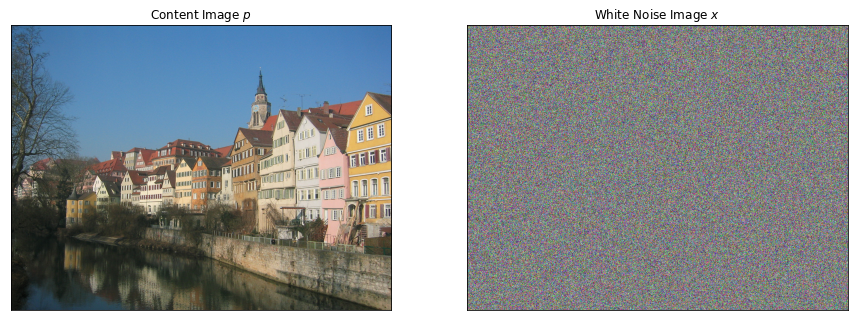

In [4]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
content = io.imread('img/content/tubingen.jpg')
ax = plt.imshow(content)
plt.title('Content Image $p$')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
plt.subplot(1, 2, 2)
noise = np.random.uniform(0, 1, size=content.shape)
ax = plt.imshow(noise)
plt.title('White Noise Image $x$')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

## `block1_conv1`

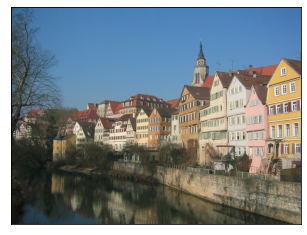

100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


In [5]:
output = reconstruct_content(
    content=content,
    layer_name='block1_conv1',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block1_conv1')
)
io.imsave('img/content-reconstruction/block1_conv1.png', output)

## `block2_conv1`

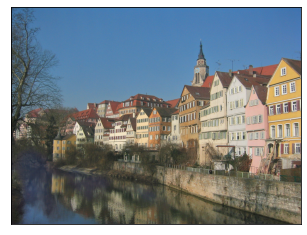

100%|██████████| 3/3 [00:22<00:00,  7.36s/it]


In [6]:
output = reconstruct_content(
    content=content,
    layer_name='block2_conv1',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block2_conv1')
)
io.imsave('img/content-reconstruction/block2_conv1.png', output)

## `block3_conv1`

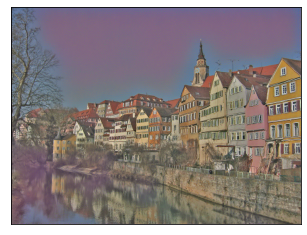

100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


In [7]:
output = reconstruct_content(
    content=content,
    layer_name='block3_conv1',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block3_conv1')
)
io.imsave('img/content-reconstruction/block3_conv1.png', output)

## `block4_conv1`

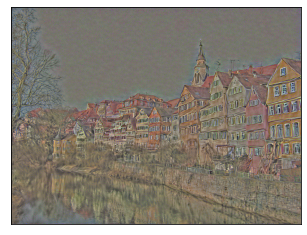

100%|██████████| 3/3 [00:31<00:00, 10.42s/it]


In [8]:
output = reconstruct_content(
    content=content,
    layer_name='block4_conv1',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block4_conv1')
)
io.imsave('img/content-reconstruction/block4_conv1.png', output)

## `block5_conv1`

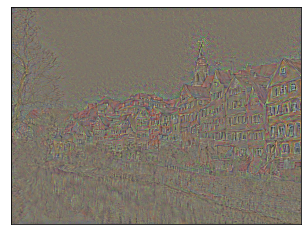

100%|██████████| 3/3 [00:37<00:00, 12.55s/it]


In [9]:
output = reconstruct_content(
    content=content,
    layer_name='block5_conv1',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block5_conv1')
)
io.imsave('img/content-reconstruction/block5_conv1.png', output)

## `block4_conv2`

**Gatys et al. use `block4_conv2` as the final content representation.**

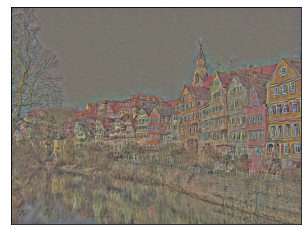

100%|██████████| 3/3 [00:32<00:00, 10.72s/it]


In [10]:
output = reconstruct_content(
    content=content,
    layer_name='block4_conv2',
    optimize=L_BFGS(),
    iterations=ITERATIONS,
    callback=build_callback('build/content/block4_conv2')
)
io.imsave('img/content-reconstruction/block4_conv2.png', output)